### Importing Necessary Libraries

In [102]:
# Core Python Libraries
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
import itertools  # Functions creating iterators for efficient looping.
from dataclasses import dataclass  # Class decorator for adding special methods to classes.

# PyTorch-related Libraries (Deep Learning)
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader, Subset, random_split  # Dataset and DataLoader for managing and batching data.
import torchvision # PyTorch's computer vision library.
from torchvision import datasets, transforms  # Datasets and transformations for image processing.
import torchvision.datasets as datasets  # Datasets for computer vision tasks.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Make grid for displaying images.
import torchvision.models as models  # Pretrained models for transfer learning.
import torchvision.transforms.functional as TF  # Functional transformations for image preprocessing.
import torchsummary # PyTorch model summary for Keras-like model summary.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for handling class imbalance in object detection.
from torchmetrics import MeanMetric  # Intersection over Union (IoU) metric for object detection.
from torchmetrics.classification import MultilabelF1Score, MultilabelRecall, MultilabelPrecision, MultilabelAccuracy  # Multilabel classification metrics.

import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

# Geospatial Data Processing Libraries
import rasterio  # Library for reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation functions.
from rasterio.enums import Resampling  # Resampling methods used for resizing raster data.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation and Analysis Libraries
import pandas as pd  # Data analysis and manipulation library for DataFrames and CSVs.
import numpy as np  # Numpy for array operations and numerical computations.
from sklearn.metrics import confusion_matrix, accuracy_score  # Evaluation metrics for classification models.

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting library for creating static and interactive visualizations.
import seaborn as sns  # High-level interface for drawing attractive statistical graphics.

# Utilities
from tqdm import tqdm  # Progress bar for loops and processes.
from PIL import Image  # Image handling, opening, manipulating, and saving.
import ast  # Abstract Syntax Trees for parsing Python code.
import requests  # HTTP library for sending requests.
import zstandard as zstd  # Zstandard compression for fast compression and decompression.
from collections import Counter # Counter for counting hashable objects.
import certifi  # Certificates for verifying HTTPS requests.
import ssl  # Secure Sockets Layer for secure connections.
import urllib.request  # URL handling for requests.

In [80]:
pl.seed_everything(42)  # Set seed for reproducibility.

Seed set to 42


42

In [81]:
@dataclass
class Config:
    num_epochs = 10  # Number of epochs for training.
    batch_size = 64  # Batch size for training.
    learning_rate = 1e-3  # Learning rate for training.
    input_size = 224  # Input size for the model.
    resize = 256  # Resize size for the images.
    num_classes = 10  # Number of classes in the dataset.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Device for training.
    num_workers = 4  # Number of workers for the DataLoader.
    optimizer = optim.Adam # Optimizer for training.
    channels = 3 # Number of channels in the images.

    image_mean = [0.485, 0.456, 0.406]  # Image mean for normalization.
    image_std = [0.229, 0.224, 0.225]  # Image standard deviation for normalization.

In [62]:
# Disable SSL verification (not recommended for production)
ssl._create_default_https_context = ssl._create_unverified_context

# Download the EuroSAT dataset
euro_sat_dataset = datasets.EuroSAT(root="./data", download=True, transform=transforms)

# Get the full path of the dataset
dataset_root_path = os.path.abspath(euro_sat_dataset.root)
dataset_full_path = os.path.join(dataset_root_path, 'eurosat', '2750')  # '2750' is the subdirectory where the dataset files are stored

### Creating a Custom Dataset Class
This is a custom PyTorch Dataset class designed to load images and labels (if available) for each set. The PyTorch "Dataset" class is essential for efficient and organized data handling in machine learning tasks. It provides a standardized interface to load and preprocess data samples from various sources. Encapsulating the dataset into a single object simplifies data management and enables seamless integration with other PyTorch components like data loaders and models. 

In [63]:
class EuroSATDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)

        return img, label

### Custom LightningDataModule class to Load dataset
This class inherits from Lightning’s LightningDataModule class and encapsulates the following steps:

1) Download the dataset.
2) Create train and validation splits.
3) Create a Dataset class object for each split with appropriate transformations.
4) Create DataLoader objects for each split.

The class methods are defined to do the following tasks:
1) prepare_data(..): This method is used for data preparation, like downloading and one-time preprocessing with the dataset. When training on a distributed GPU, this will be called from a single GPU.
2) setup(...):  When you want to perform data operations on every GPU, this method is apt for it will call from every GPU. For example, perform train/val/test splits.
3) train_dataloader(...): This method returns the train dataloader.
4) val_dataloader(...): This method returns validation dataloader(s).
5) test_dataloader(...):  This method returns test dataloader(s).

In [ ]:
class EuroSATDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size=32, num_workers=4):
        super(EuroSATDataModule, self).__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        train_size = int(0.8 * len(self.dataset))
        val_size = len(self.dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(self.dataset, [train_size, val_size])

    def prepare_data(self):
        pass
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=self.num_workers)

### Custom Lightning Module Class for the Model
Create a class that contains the following main methods: 

In [ ]:
class EuroSATModel(pl.LightningModule):
    def __init__(self, num_classes=10):
        super(EuroSATModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=Config.learning_rate)
        return optimizer
    
    def on_train_epoch_end(self) -> None:
        return super().on_train_epoch_end()
    def on_validation_epoch_end(self) -> None:
        return super().on_validation_epoch_end()

### Defining Transformations

In [67]:
# Define the transformations for the dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(Config.input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(Config.image_mean, Config.image_std)
])
test_transform = transforms.Compose([
    transforms.Resize(Config.resize),
    transforms.CenterCrop(Config.input_size),
    transforms.ToTensor(),
    transforms.Normalize(Config.image_mean, Config.image_std)
])

### Data Preparation

In [82]:
dataset = datasets.ImageFolder(dataset_full_path)

categories = dataset.classes
print(f"Class names: {categories}")
print(f"Number of classes: {len(categories)}")
print(f"Number of images: {len(dataset)}")

# Split the dataset into training and testing sets
train_size = 0.8
indices = list(range(len(dataset)))
split = int(np.floor(train_size * len(dataset)))
np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]

# Creating subsets of the dataset for train and test using the indices
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

# Apply transformations to the training and testing datasets
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# Create DataLoader objects for the training and testing datasets
train_loader = DataLoader(train_data, batch_size=Config.batch_size, num_workers=Config.num_workers, shuffle=True)
test_loader = DataLoader(test_data, batch_size=Config.batch_size, num_workers=Config.num_workers, shuffle=False)


Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of classes: 10
Number of images: 27000


### Displaying Sample Images

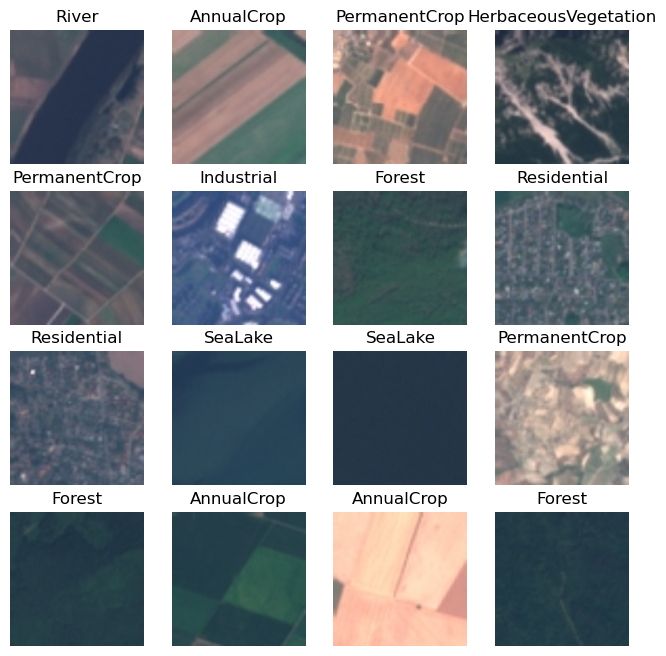

In [87]:
def show_sample_images(dataloader, class_names, n=4):
    """
    Displays a grid of sample images from the dataloader with their corresponding class names.

    Parameters:
    - dataloader: DataLoader object that provides batches of images and labels.
    - class_names: List of class names corresponding to the labels.
    - n: Number of rows and columns in the grid (default is 3 for a 3x3 grid).
    """
    # Get a batch of images and labels from the dataloader
    inputs, classes = next(iter(dataloader))

    # Create a figure with subplots arranged in an n x n grid
    fig, axes = plt.subplots(n, n, figsize=(8, 8))

    # Iterate over each subplot position in the grid
    for i in range(n):
        for j in range(n):
            # Get the image from the batch and convert from CHW to HWC format
            image = inputs[i * n + j].numpy().transpose((1, 2, 0))

            # Reverse the normalization of the image (assuming imagenet_std and imagenet_mean are defined)
            image = np.clip(np.array(Config.image_std) * image + np.array(Config.image_mean), 0, 1)

            # Get the class name for the current image
            title = class_names[classes[i * n + j]]

            # Display the image in the current subplot
            axes[i, j].imshow(image)
            axes[i, j].set_title(title)  # Set the title of the subplot to the class name
            axes[i, j].axis('off')  # Hide the axis for a cleaner look

    # Show the plot with the grid of images
    plt.show()

# Call the function to display sample images from the train_loader
show_sample_images(train_loader, categories)

### Building the Model

In [96]:
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer with a new linear layer
model.fc = torch.nn.Linear(model.fc.in_features, Config.num_classes)

# Move the model to the device (GPU if available)
model = model.to(Config.device)

# Print the model architecture
torchsummary.summary(model, (3, Config.input_size, Config.input_size))

C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [97]:
# Define the loss function and optimizer
criteria = nn.CrossEntropyLoss() # Cross-entropy loss for multi-class classification

optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate) # Adam optimizer with learning rate

In [98]:
def train(model, dataloader, criteria, optimizer, device):
    # Set the model to training mode
    model.train()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0

    # Loop over data batches in the dataloader
    for inputs, labels in tqdm(dataloader):
        # Move inputs and labels to the specified device (e.g., GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to avoid accumulation
        optimizer.zero_grad()

        # Forward pass: compute outputs by passing inputs to the model
        outputs = model(inputs)

        # Compute the loss between model outputs and actual labels
        loss = criteria(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model parameters based on the computed gradients
        optimizer.step()

        # Get the predicted class with the highest score
        _, preds = torch.max(outputs, 1)

        # Update the running loss (scaled by the batch size)
        running_loss += loss.item() * inputs.size(0)

        # Update the count of correct predictions
        running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Return the average loss and accuracy for the epoch
    return epoch_loss, epoch_acc

In [99]:
def evaluate(model, dataloader, criteria, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track loss, correct predictions, and store all predictions and labels
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Iterate over the data in the dataloader
        for inputs, labels in tqdm(dataloader):
            # Move inputs and labels to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass to get outputs from the model
            outputs = model(inputs)

            # Calculate the loss
            loss = criteria(outputs, labels)

            # Get the predicted class by finding the index with the highest score
            _, preds = torch.max(outputs, 1)

            # Update the running loss and correct predictions count
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for later use (e.g., for metrics computation)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    # Return the computed metrics
    return epoch_loss, epoch_acc, all_labels, all_preds

In [101]:
# Initialize the best model weights to the current state of the model
best_model_wts = model.state_dict()

# Set the best loss to infinity initially so that any loss will be lower
best_loss = float('inf')

# Set the number of epochs to train the model
num_epochs = 30

# Loop over the dataset multiple times (each loop is one epoch)
for epoch in range(num_epochs):
    # Print the current epoch number
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model and get the training loss and accuracy
    train_loss, train_acc = train(model, train_loader, criteria, optimizer, Config.device)

    # Print the training loss and accuracy for the current epoch
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    # Evaluate the model on the validation set and get the loss, accuracy, all labels, and all predictions
    val_loss, val_acc, all_labels, all_preds = evaluate(model, test_loader, criteria, Config.device)

    # Print the validation loss and accuracy for the current epoch
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # If the current validation loss is lower than the best loss seen so far
    if val_loss < best_loss:
        # Update the best loss to the current validation loss
        best_loss = val_loss
        # Save the model weights as the best model weights
        best_model_wts = model.state_dict()

# Load the best model weights into the model
model.load_state_dict(best_model_wts)

# Define the directory where the model will be saved
model_dir = r"C:\Users\isaac\FYPCodeLatest\models"

# Create the directory if it does not exist
os.makedirs(model_dir, exist_ok=True)

# Define the file path for saving the best model weights
model_file = os.path.join(model_dir, 'best_model.pth')

# Save the best model weights to the file
torch.save(model.state_dict(), model_file)

# Print a message indicating that the model has been saved
print(f'Model saved to {model_file}')

Epoch 1/30


100%|██████████| 338/338 [01:33<00:00,  3.62it/s]


Train Loss: 0.3397 Acc: 0.8913


100%|██████████| 85/85 [00:20<00:00,  4.06it/s]


Val Loss: 0.3557 Acc: 0.8824
Epoch 2/30


100%|██████████| 338/338 [01:28<00:00,  3.83it/s]


Train Loss: 0.1811 Acc: 0.9401


100%|██████████| 85/85 [00:19<00:00,  4.42it/s]


Val Loss: 0.1574 Acc: 0.9502
Epoch 3/30


100%|██████████| 338/338 [01:28<00:00,  3.83it/s]


Train Loss: 0.1365 Acc: 0.9537


100%|██████████| 85/85 [00:20<00:00,  4.20it/s]


Val Loss: 0.1431 Acc: 0.9544
Epoch 4/30


100%|██████████| 338/338 [01:31<00:00,  3.71it/s]


Train Loss: 0.1219 Acc: 0.9597


100%|██████████| 85/85 [00:18<00:00,  4.69it/s]


Val Loss: 0.2120 Acc: 0.9278
Epoch 5/30


100%|██████████| 338/338 [01:24<00:00,  3.98it/s]


Train Loss: 0.0989 Acc: 0.9665


100%|██████████| 85/85 [00:17<00:00,  4.75it/s]


Val Loss: 0.1912 Acc: 0.9350
Epoch 6/30


100%|██████████| 338/338 [01:25<00:00,  3.94it/s]


Train Loss: 0.1013 Acc: 0.9666


100%|██████████| 85/85 [00:18<00:00,  4.70it/s]


Val Loss: 0.1171 Acc: 0.9626
Epoch 7/30


100%|██████████| 338/338 [01:29<00:00,  3.76it/s]


Train Loss: 0.0805 Acc: 0.9744


100%|██████████| 85/85 [00:19<00:00,  4.31it/s]


Val Loss: 0.1654 Acc: 0.9463
Epoch 8/30


100%|██████████| 338/338 [01:30<00:00,  3.73it/s]


Train Loss: 0.0679 Acc: 0.9765


100%|██████████| 85/85 [00:18<00:00,  4.50it/s]


Val Loss: 0.1144 Acc: 0.9661
Epoch 9/30


100%|██████████| 338/338 [01:29<00:00,  3.79it/s]


Train Loss: 0.0645 Acc: 0.9785


100%|██████████| 85/85 [00:18<00:00,  4.48it/s]


Val Loss: 0.1927 Acc: 0.9452
Epoch 10/30


100%|██████████| 338/338 [01:18<00:00,  4.30it/s]


Train Loss: 0.0599 Acc: 0.9794


100%|██████████| 85/85 [00:17<00:00,  4.89it/s]


Val Loss: 0.1224 Acc: 0.9613
Epoch 11/30


100%|██████████| 338/338 [01:17<00:00,  4.35it/s]


Train Loss: 0.0452 Acc: 0.9857


100%|██████████| 85/85 [00:17<00:00,  4.92it/s]


Val Loss: 0.1382 Acc: 0.9581
Epoch 12/30


100%|██████████| 338/338 [01:20<00:00,  4.20it/s]


Train Loss: 0.0529 Acc: 0.9819


100%|██████████| 85/85 [00:17<00:00,  4.95it/s]


Val Loss: 0.1489 Acc: 0.9574
Epoch 13/30


100%|██████████| 338/338 [01:17<00:00,  4.38it/s]


Train Loss: 0.0467 Acc: 0.9854


100%|██████████| 85/85 [00:17<00:00,  4.88it/s]


Val Loss: 0.1393 Acc: 0.9613
Epoch 14/30


100%|██████████| 338/338 [01:25<00:00,  3.97it/s]


Train Loss: 0.0434 Acc: 0.9857


100%|██████████| 85/85 [00:18<00:00,  4.51it/s]


Val Loss: 0.2090 Acc: 0.9457
Epoch 15/30


100%|██████████| 338/338 [01:25<00:00,  3.96it/s]


Train Loss: 0.0259 Acc: 0.9918


100%|██████████| 85/85 [00:20<00:00,  4.23it/s]


Val Loss: 0.1639 Acc: 0.9570
Epoch 16/30


100%|██████████| 338/338 [01:22<00:00,  4.12it/s]


Train Loss: 0.0344 Acc: 0.9888


100%|██████████| 85/85 [00:19<00:00,  4.42it/s]


Val Loss: 0.1204 Acc: 0.9652
Epoch 17/30


100%|██████████| 338/338 [01:23<00:00,  4.07it/s]


Train Loss: 0.0375 Acc: 0.9880


100%|██████████| 85/85 [00:18<00:00,  4.55it/s]


Val Loss: 0.2074 Acc: 0.9444
Epoch 18/30


100%|██████████| 338/338 [01:24<00:00,  4.02it/s]


Train Loss: 0.0206 Acc: 0.9927


100%|██████████| 85/85 [00:19<00:00,  4.44it/s]


Val Loss: 0.1449 Acc: 0.9615
Epoch 19/30


100%|██████████| 338/338 [01:19<00:00,  4.24it/s]


Train Loss: 0.0422 Acc: 0.9861


100%|██████████| 85/85 [00:18<00:00,  4.71it/s]


Val Loss: 0.0991 Acc: 0.9735
Epoch 20/30


100%|██████████| 338/338 [01:19<00:00,  4.27it/s]


Train Loss: 0.0286 Acc: 0.9905


100%|██████████| 85/85 [00:19<00:00,  4.46it/s]


Val Loss: 0.1165 Acc: 0.9667
Epoch 21/30


100%|██████████| 338/338 [01:22<00:00,  4.10it/s]


Train Loss: 0.0211 Acc: 0.9932


100%|██████████| 85/85 [00:18<00:00,  4.52it/s]


Val Loss: 0.1407 Acc: 0.9611
Epoch 22/30


100%|██████████| 338/338 [01:20<00:00,  4.19it/s]


Train Loss: 0.0160 Acc: 0.9948


100%|██████████| 85/85 [00:18<00:00,  4.57it/s]


Val Loss: 0.1478 Acc: 0.9670
Epoch 23/30


100%|██████████| 338/338 [01:20<00:00,  4.21it/s]


Train Loss: 0.0295 Acc: 0.9910


100%|██████████| 85/85 [00:18<00:00,  4.64it/s]


Val Loss: 0.1744 Acc: 0.9557
Epoch 24/30


100%|██████████| 338/338 [01:23<00:00,  4.03it/s]


Train Loss: 0.0310 Acc: 0.9904


100%|██████████| 85/85 [00:20<00:00,  4.24it/s]


Val Loss: 0.1679 Acc: 0.9544
Epoch 25/30


100%|██████████| 338/338 [01:22<00:00,  4.12it/s]


Train Loss: 0.0178 Acc: 0.9938


100%|██████████| 85/85 [00:18<00:00,  4.61it/s]


Val Loss: 0.1747 Acc: 0.9567
Epoch 26/30


100%|██████████| 338/338 [01:20<00:00,  4.20it/s]


Train Loss: 0.0207 Acc: 0.9934


100%|██████████| 85/85 [00:20<00:00,  4.24it/s]


Val Loss: 0.1285 Acc: 0.9702
Epoch 27/30


100%|██████████| 338/338 [01:22<00:00,  4.09it/s]


Train Loss: 0.0182 Acc: 0.9941


100%|██████████| 85/85 [00:18<00:00,  4.71it/s]


Val Loss: 0.1312 Acc: 0.9659
Epoch 28/30


100%|██████████| 338/338 [01:22<00:00,  4.11it/s]


Train Loss: 0.0202 Acc: 0.9939


100%|██████████| 85/85 [00:19<00:00,  4.43it/s]


Val Loss: 0.1937 Acc: 0.9541
Epoch 29/30


100%|██████████| 338/338 [01:23<00:00,  4.05it/s]


Train Loss: 0.0267 Acc: 0.9918


100%|██████████| 85/85 [00:19<00:00,  4.44it/s]


Val Loss: 0.1485 Acc: 0.9646
Epoch 30/30


100%|██████████| 338/338 [01:20<00:00,  4.22it/s]


Train Loss: 0.0179 Acc: 0.9947


100%|██████████| 85/85 [00:21<00:00,  3.96it/s]

Val Loss: 0.1460 Acc: 0.9646
Model saved to C:\Users\isaac\FYPCodeLatest\models\best_model.pth


In [ ]:
# Load a pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes in your dataset
# The original ResNet-50 has 1000 output features for 1000 classes (ImageNet dataset)
# We replace it with a new linear layer that has 'len(class_names)' output features (number of classes in your dataset)
model.fc = torch.nn.Linear(model.fc.in_features, Config.num_classes)

# Load the trained model weights from a file
# 'model_file' is the path to the file containing the model weights
model.load_state_dict(torch.load(model_file))

# Move the model to the appropriate device (CPU or GPU)
# 'device' is a variable specifying whether to use CPU or GPU (e.g., device = torch.device('cuda') or device = torch.device('cpu'))
model = model.to(Config.device)

# Set the model to evaluation mode
# This is important because it changes the behavior of some layers, like dropout and batch normalization, which should behave differently during training and evaluation
model.eval()

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # If normalization is set to True, normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Print a message indicating whether the confusion matrix is normalized or not
    print("Confusion matrix, without normalization" if not normalize else "Normalized confusion matrix")

    # Create a new figure with a specified size
    plt.figure(figsize=(10, 10))
    # Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Set the title of the plot
    plt.title(title)
    # Add a color bar to the side of the plot
    plt.colorbar()
    # Set tick marks at each class index
    tick_marks = np.arange(len(classes))
    # Label the x-axis ticks with the class names, rotated 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    # Label the y-axis ticks with the class names
    plt.yticks(tick_marks, classes)

    # Format the values in the confusion matrix as float with 2 decimals if normalized, otherwise as integers
    fmt = '.2f' if normalize else 'd'
    # Determine a threshold to change text color for better readability
    thresh = cm.max() / 2.
    # Iterate through each cell in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Place the text in the middle of each cell
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Adjust the layout for better fit
    plt.tight_layout()
    # Label the y-axis as 'True label'
    plt.ylabel('True label')
    # Label the x-axis as 'Predicted label'
    plt.xlabel('Predicted label')

# Calculate and plot the confusion matrix
# `all_labels` contains the true labels and `all_preds` contains the predicted labels
cm = confusion_matrix(all_labels, all_preds)
# `class_names` contains the list of class names
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

# Calculate the overall accuracy of the model
accuracy = accuracy_score(all_labels, all_preds)
# Print the overall accuracy
print(f'Overall accuracy: {accuracy:.4f}')